614.9985714285714
283822 462947
29 1
639.9985714285714
101660 266376
29 1
634.9985714285714
44040 478930
29 1
644.9985714285714
62389 492325
29 1
649.9985714285714
40665 491679
29 1
639.9985714285714
44558 488759
29 1
669.9985714285714
64295 504082
29 1
644.9985714285714
57827 487975
29 1
724.9985714285714
61135 344841
29 1
679.9985714285714
41479 513688
29 1
663.9985714285714
102833 341199
29 1
674.9985714285714
57426 415929
29 1
685.9985714285714
58234 257452
29 1
673.0
52473 511684
29 1
722.9985714285714
47928 541885
29 1
[[283822. 462947.]
 [101660. 266376.]
 [ 44040. 478930.]
 [ 62389. 492325.]
 [ 40665. 491679.]
 [ 44558. 488759.]
 [ 64295. 504082.]
 [ 57827. 487975.]
 [ 61135. 344841.]
 [ 41479. 513688.]
 [102833. 341199.]
 [ 57426. 415929.]
 [ 58234. 257452.]
 [ 52473. 511684.]
 [ 47928. 541885.]]
     scr_mean   scr_std   scr_max   scr_min  scr_range  scr_kurtosis  \
S2   0.000407  0.042955  0.264927 -0.151518   0.416445      6.536496   
S3   0.001078  0.210650  0.707026 -5.12

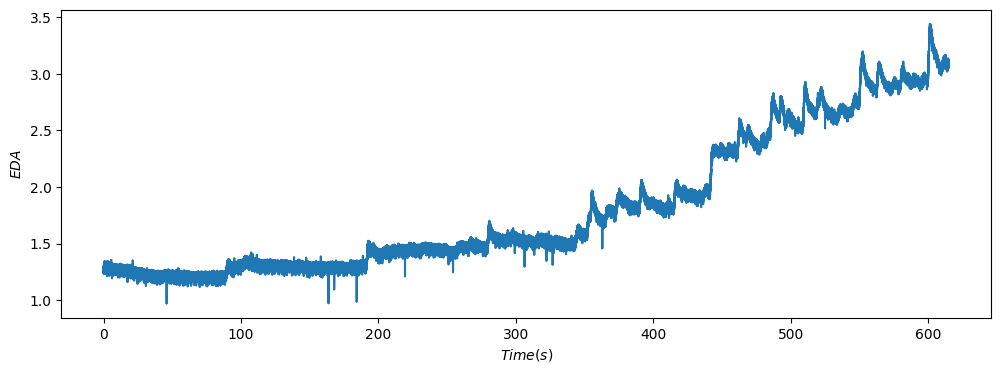

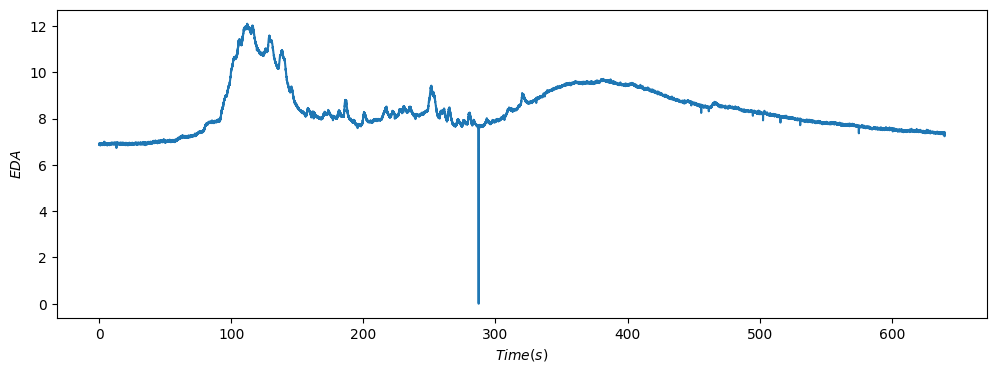

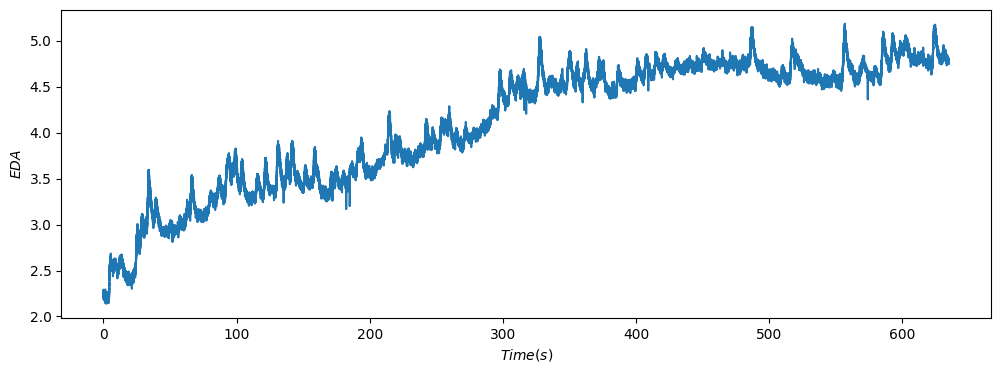

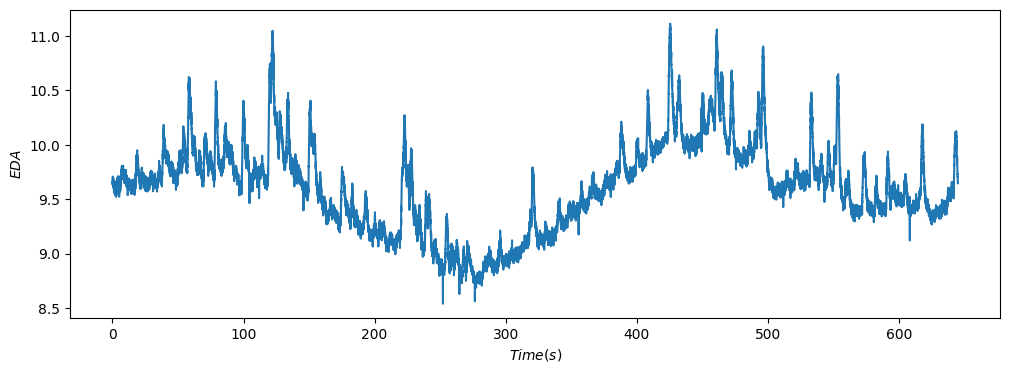

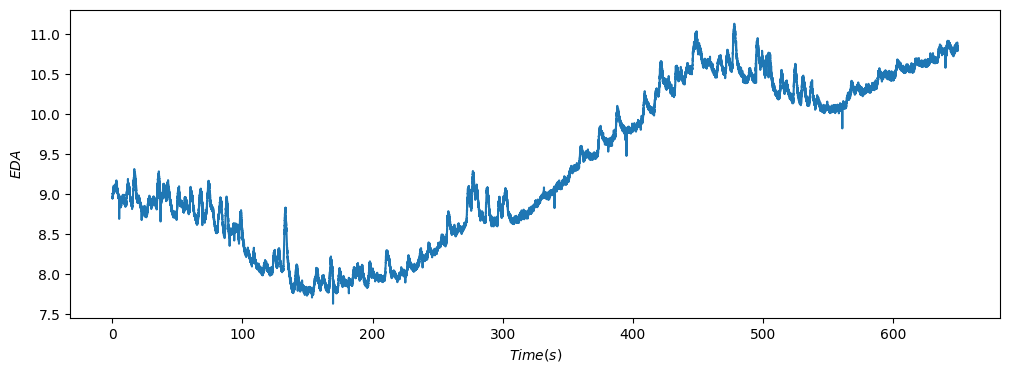

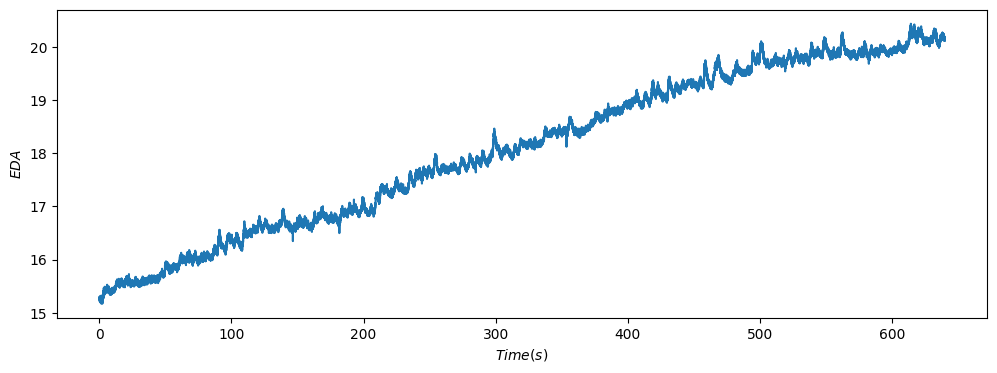

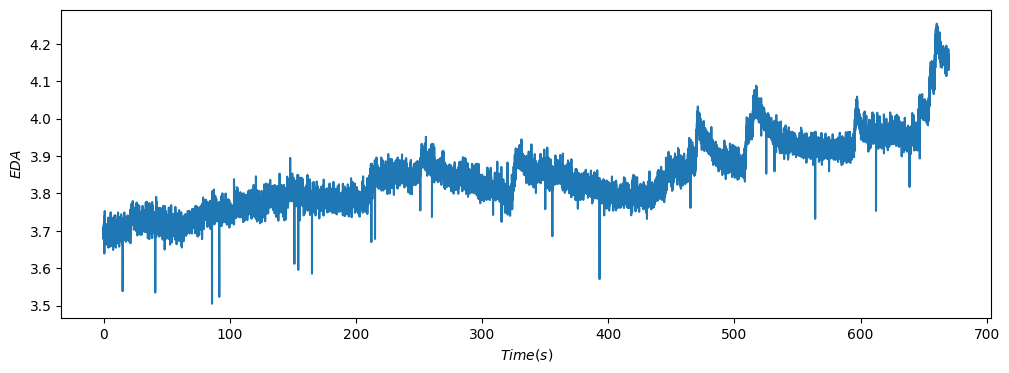

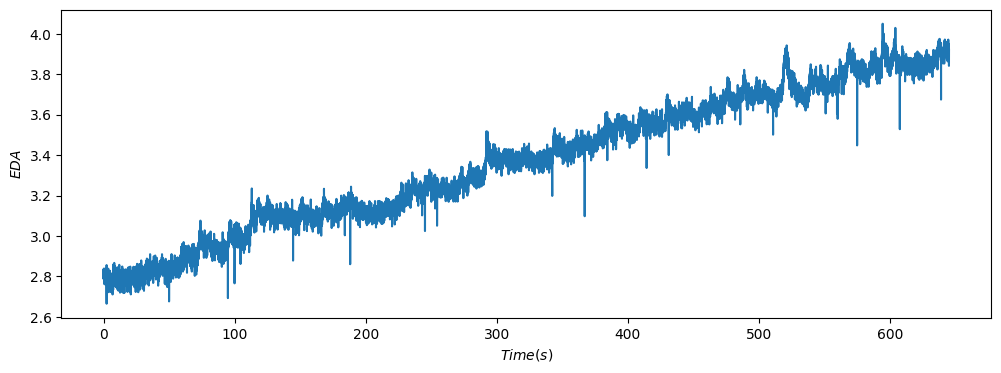

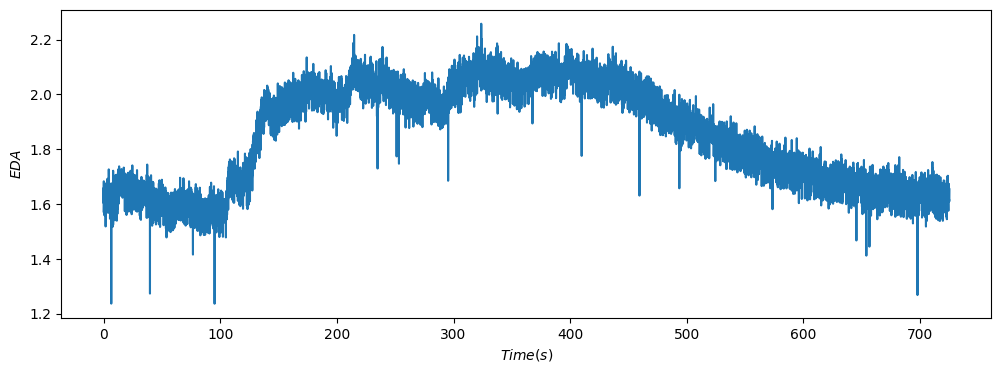

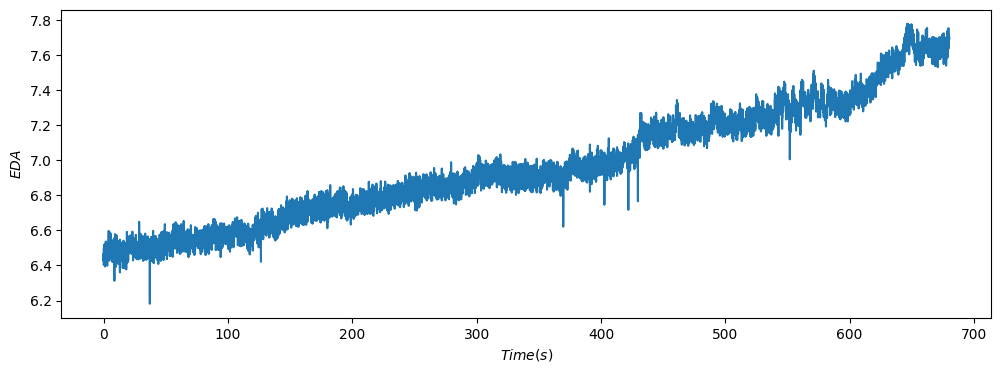

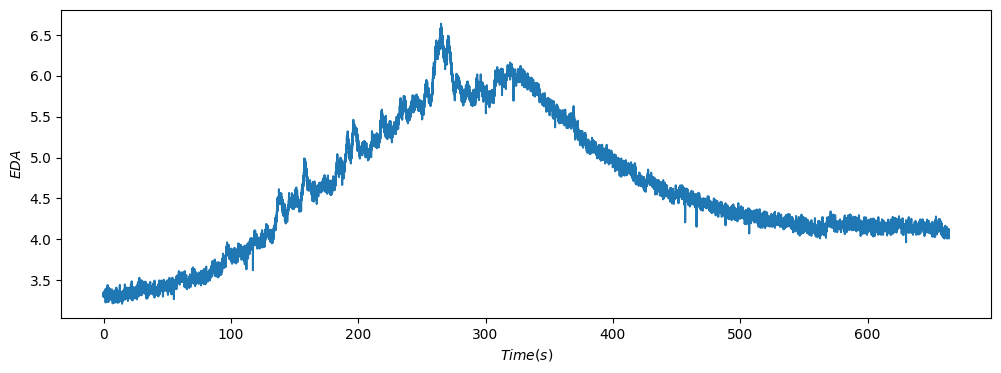

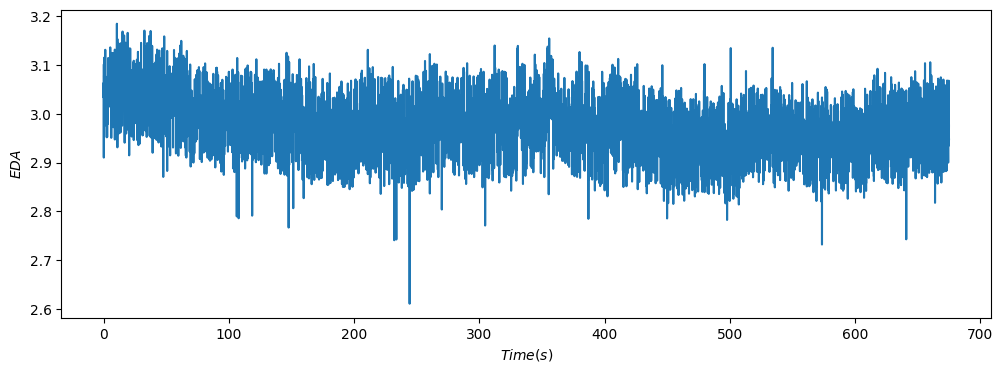

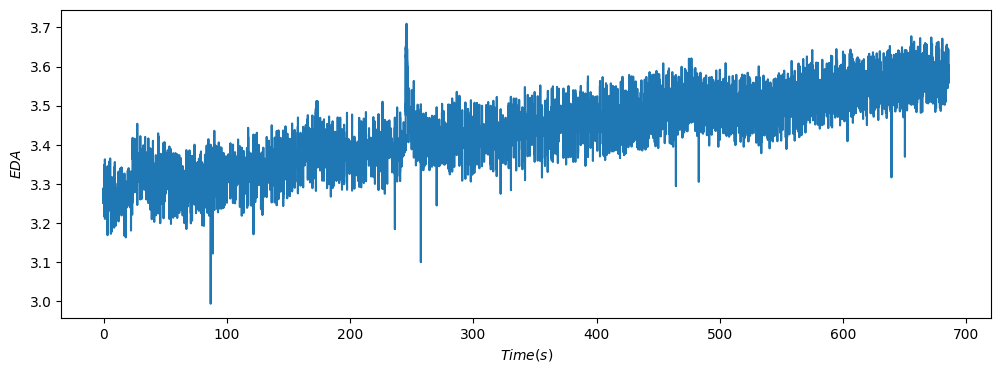

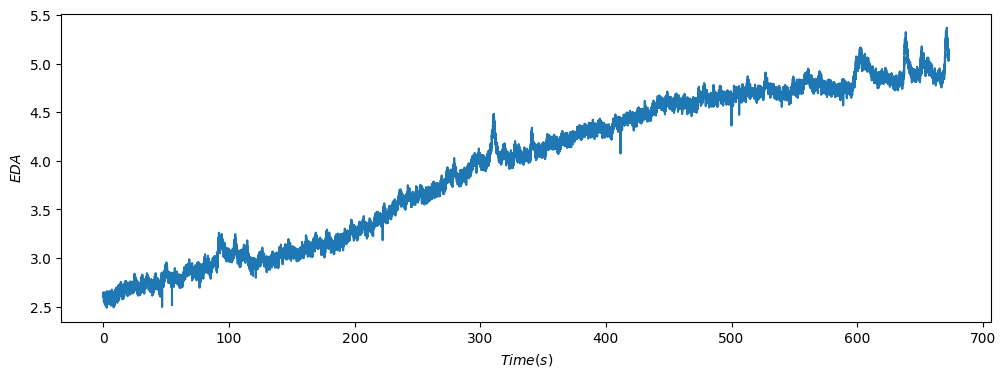

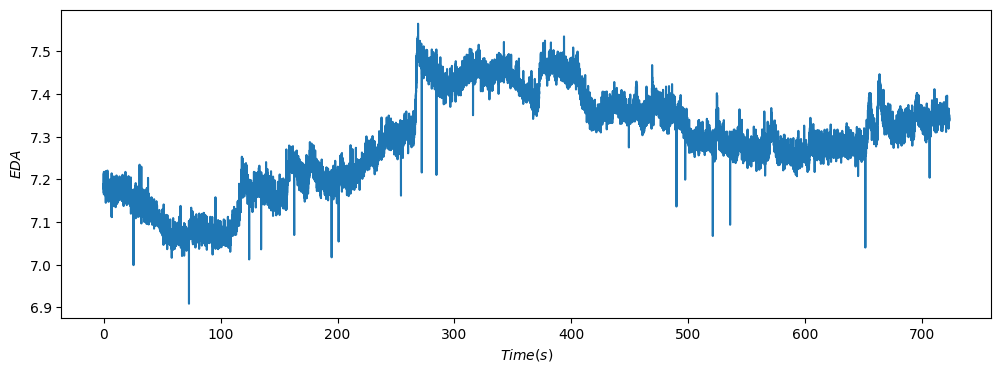

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting
import biobss #EDA analysis

import os
import pickle

from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import scipy.signal
import scipy.ndimage
import scipy.stats as stats

from os import listdir
from os.path import isfile, join, isdir

from tqdm import tqdm
#%%
# Empty dataframe and array to append data
begin_l = np.empty((0,1))
end_l = np.empty((0,1))
index_l = np.empty((0,1))
first = True
# For loop for all 15 subjects
for i in range(16): # 16
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
    if subject != 'S12': # Skip S12, because it does nog exist
        class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

        # Object instantiation
        obj_data = {}

        # Accessing class attributes and method through objects
        obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

        chest_data_dict = obj_data[subject].get_chest_data()
        chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
        #print(chest_dict_length)

        # Get labels
        labels = obj_data[subject].get_labels()
        baseline = np.asarray([idx for idx,val in enumerate(labels) if val == 2])
        #plt.plot(labels)

        eda_base=chest_data_dict['EDA'][baseline,0] # Select the EDA data

        # cut a smaller window
        sampling_rate=700
        eda=eda_base#[400*sampling_rate:420*sampling_rate]

        t=np.arange(0,eda.size*(1/sampling_rate),(1/sampling_rate))
        t1=t[:eda.size]

        # Plot the original sampled data
        plt.figure(figsize=(12,4))
        plt.plot(t1,eda)
        plt.xlabel('$Time (s)$') 
        plt.ylabel('$EDA$') 
        print(np.max(t1))

        #Filtered signal
        eda_f = biobss.edatools.filter_eda(eda, sampling_rate)

        # Plot the filtered data
        #plt.figure(figsize=(12,4))
        #plt.plot(t,eda_f)
        #plt.xlabel('$Time (s)$') 
        #plt.ylabel('$EDA$')
        
        # Decompose the signal in a tonic and phasic part
        eda = biobss.edatools.eda_decompose(eda_f, sampling_rate=sampling_rate)
        tonic = eda.iloc[:,0]
        phasic = eda.iloc[:,1]
        #print(eda)

        # Zero pad the signal to avoid errors
        zero_pad = 55*sampling_rate-1
        phasic = np.pad(phasic, (zero_pad, 0))
        phasic = np.insert(phasic,0,0)
        phasic = np.pad(phasic, (5, 0))
        t2 = np.arange(0,phasic.size*(1/sampling_rate),(1/sampling_rate))
        #print(phasic)
        #print(phasic.size)
        #print(t2.size)

        # Plot the zero padded signal
        #plt.figure(figsize=(12,4))
        #plt.plot(t2,phasic,label='phasic')
        ##plt.plot(t2,tonic,label='tonic')
        #plt.xlabel('$Time (s)$') 
        #plt.ylabel('$EDA$')

        # Peak detection
        peaks, properties = scipy.signal.find_peaks(phasic)
        heights, left_bases, right_bases = scipy.signal.peak_prominences(phasic, peaks)
        widths, width_heights, left_ips, __ = scipy.signal.peak_widths(phasic, peaks, rel_height=0.9)
        __, __, __, right_ips = scipy.signal.peak_widths(phasic, peaks, rel_height=0.5)

        heights1 = np.delete(heights, np.where(heights == np.max(heights)))
        heights2 = np.delete(heights1, np.where(heights1 == np.max(heights1)))

        # find the indices with an amplitude larger that 0.1
        keep = np.full(len(peaks), True)
        amplitude_min=0.2*np.max(heights2)
        time_min=50
        keep[heights<amplitude_min] = False

        # only keep those 
        peaks=peaks[keep]
        heights=heights[keep]
        widths=widths[keep]
        left_bases = left_bases[keep]
        right_bases = right_bases[keep]
        width_heights = width_heights[keep]
        left_ips = left_ips[keep]
        right_ips = right_ips[keep]

        #keep peaks inside a certain time interval
        keep1 = np.full(len(peaks), True)
        peak_diff = [0]
        for i in range(peaks.size-1):
          peak_diff_enum = t2[peaks[i+1]]-t2[peaks[i]]
          peak_diff.append(peak_diff_enum)

        keep1[np.array(peak_diff)>time_min] = False

        peaks=peaks[keep1]
        heights=heights[keep1]
        widths=widths[keep1]
        left_bases = left_bases[keep1]
        right_bases = right_bases[keep1]
        width_heights = width_heights[keep1]
        left_ips = left_ips[keep1]
        right_ips = right_ips[keep1]

        ## plot the peaks
        #plt.figure(figsize=(12,4))
        #plt.plot(t2,phasic,label='phasic')
        #plt.plot(t2[peaks],phasic[peaks],'o',label='peaks')
        ## labels and titles
        #plt.xlabel('$Time (s)$') 
        #plt.ylabel('$EDA$')
        #plt.legend()

        ##Taking the time interval between of the cluster of peaks with 5 sec extra
        tf = t2[peaks[0]-5*sampling_rate:peaks[-1]+5*sampling_rate] 
        phasic = phasic[peaks[0]-5*sampling_rate:peaks[-1]+5*sampling_rate]
        #print(tf.size)
        #print(phasic.size)

        # plot the interval
        #plt.figure(figsize=(12,4))
        #plt.plot(tf,phasic,label='phasic')
        ## labels and titles
        #plt.xlabel('$Time (s)$') 
        #plt.ylabel('$EDA$')
        #plt.legend()

        # Index samples interval
        start = peaks[1]-5*sampling_rate
        end = peaks[-1]+5*sampling_rate
        print(start,end)

        # Append all start and end indices to matrix
        begin_l = np.append(begin_l, start[np.newaxis][np.newaxis], axis = 0)
        end_l = np.append(end_l, end[np.newaxis][np.newaxis], axis = 0)
        #print(begin_l)
        #print(end_l)

        #Features from EDA signal
        tonic_phase_feat = biobss.edatools.from_decomposed(phasic, tonic, sampling_rate)
        # print(len(tonic_phase_feat))
        # print(len([tonic_phase_feat]))
        #eda_feat = biobss.edatools.from_signal(eda_f, sampling_rate)
        #eda_freq_feat = biobss.edatools.eda_freq_features(eda)
        #eda_hjorth_feat = biobss.edatools.eda_hjorth_features(eda)
        #eda_sig_feat = biobss.edatools.eda_signal_features(eda)
        #eda_stat_feat = biobss.edatools.eda_stat_features(eda)

        #Features from tonic
        #tonic_feat = biobss.edatools.from_scl(tonic)

        ##Features from phasic
        #phasic_feat = biobss.edatools.from_scr(phasic)

        # Convert dictionary to Dataframe
        if first:
            DF_feat = pd.DataFrame(None, columns=tonic_phase_feat.keys())
            first = False
        index = str(subject)
        # print(tonic_phase_feat.keys())
        print(len(tonic_phase_feat.keys()), len([tonic_phase_feat]))
        DF_feat.loc[index] = tonic_phase_feat
        # DF_feat1 = pd.DataFrame.from_dict(str(subject), [tonic_phase_feat])
        #DF_feat2 = pd.DataFrame.from_dict([eda_freq_feat])
        #DF_feat3 = pd.DataFrame.from_dict([eda_sig_feat])
        # DF_feat = pd.concat([DF_feat,DF_feat1])
        #DF_feat = pd.concat([DF_feat,DF_feat2], axis = 1)
        #DF_feat = pd.concat([DF_feat,DF_feat3], axis = 1)
        #print(DF_feat)

#%%
# Combine begin and end index matrices
index_l = np.append(begin_l, end_l, axis = 1)
print(index_l)

# Fill the Nan with the median of the values of the column
DF_feat.fillna(DF_feat.median(), inplace = True)
print(DF_feat)

# Convert to csv file
DF_feat.to_csv("EDA_features.csv")